# CDAW CME Catalog Analysis Notebook - Properties
This notebook is for analyzing current CDAW CME catalog to look for differences in CMEs.

Want to understand estimated properties of CME events and build a histogram/plots of this 
data.

In [1]:
import requests
import pandas as pd

Need_To_Redownload = False
CME_Catalog_Filename = '../cme_event_catalog.csv'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
    
def plot_data (xdata, ydata, xlabel="", ylabel="", title="", alpha=1.0, ylog:bool=False, xlog:bool=False):

    fig, ax = plt.subplots()
    #plt.style.use('fivethirtyeight')
    
    ax.plot(xdata, ydata, 'ro', alpha=alpha)
    ax.set_title(title)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    if ylog:
        ax.set_yscale('log')

    if xlog:
        ax.set_xscale('log')
    
    
def plot_hist(data, what, nbins:int=100, ylog:bool=False, xlog:bool=False, xlow:int=0, xhigh:int=None, nofill:bool=False):
    
    fig, ax = plt.subplots()
        
    if nofill:
        data.hist(ax=ax, bins=nbins, bottom=0, fill=None)
    else:
        data.hist(ax=ax, bins=nbins, bottom=0)
    ax.set_title("Histogram")
    ax.set(xlabel=what, ylabel="Num/bin")
    
    if xlow != None and xhigh != None:
        plt.xlim(xlow, xhigh)
    
    #plt.style.use('fivethirtyeight')
    if ylog:
        ax.set_yscale('log')
        
    if xlog:
        ax.set_xscale('log')

In [3]:
# load dataset
c2_c3_data = pd.read_csv(CME_Catalog_Filename)
len(c2_c3_data)

7618

In [5]:
# add datetime column

from datetime import datetime, date, time, timezone, timedelta

def get_datetime(data:pd.DataFrame, date_col:str='date-obs', time_col:str='time-obs')->list:
    # add column of python datetime for easier handling
    datetime_col = []
    for row in data.iterrows():
        date_obs = row[1][date_col]
        time_obs = row[1][time_col]

        date_obs = [int(t) for t in row[1][date_col].split('/')]
        time_obs = [int(t) for t in row[1][time_col].split(':')]

        datetime_col.append(datetime(year=date_obs[0], month=date_obs[1], day=date_obs[2], hour=time_obs[0], minute=time_obs[1], second=time_obs[2]))

    return datetime_col
    
c2_c3_data['datetime'] = get_datetime(c2_c3_data, 'Date', 'Time')
c2_c3_data.index = c2_c3_data.datetime

In [6]:
c2_c3_data[:3]

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,...,Duration_C2,Duration_C3,StartTime_C3_Delta,width,linear,mpa,mass,kinetic,accel,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
1996-01-31 06:52:13,1996/01/31,06:52:13,274,47,158,219,99,0,-12.3*,2.5e+14*,...,26582.278481,116518.987342,9746.835443,47,158,272,2.500000e+14,3.200000e+28,-12.3,1996-01-31 06:52:13
1996-02-12 05:47:26,1996/02/12,05:47:26,91,53,160,100,211,236,2.0*,1.3e+15,...,26250.000000,115062.500000,9625.000000,53,160,92,1.300000e+15,1.600000e+29,2.0,1996-02-12 05:47:26
1996-03-02 04:11:53,1996/03/02,04:11:53,88,36,108,95,120,177,1.0*,1.5e+14,...,38888.888889,170462.962963,14259.259259,36,108,86,1.500000e+14,8.700000e+27,1.0,1996-03-02 04:11:53


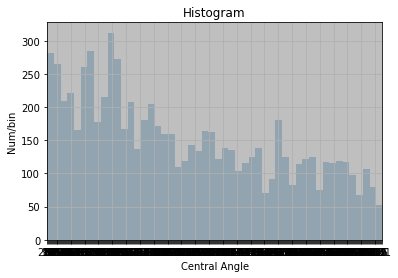

In [7]:
plot_hist(c2_c3_data['Central'], nbins=50, what='Central Angle', ylog=False, xhigh=359)

<ipython-input-8-606ae0a13224>:3: RuntimeWarning: divide by zero encountered in log10
  c2_c3_data['lmass'] = [np.log10(i) for i in c2_c3_data['nmass']]


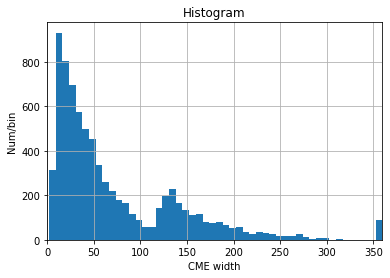

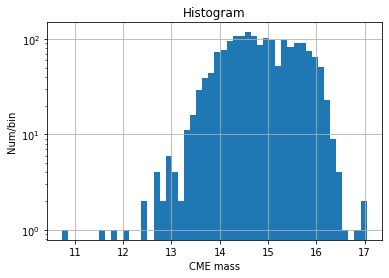

In [8]:
plot_hist(pd.to_numeric(c2_c3_data['Width']), nbins=50, what='CME width', ylog=False, xhigh=359)
c2_c3_data['nmass'] = pd.to_numeric([i.replace('*', '').replace('-','0') for i in c2_c3_data['Mass']])
c2_c3_data['lmass'] = [np.log10(i) for i in c2_c3_data['nmass']]
trimmed = c2_c3_data[c2_c3_data['lmass'] > 10.]
trimmed = trimmed[trimmed['datetime'] < '2006-01-01']
plot_hist(trimmed['lmass'], nbins=50, what='CME mass', ylog=True, xlog=False)

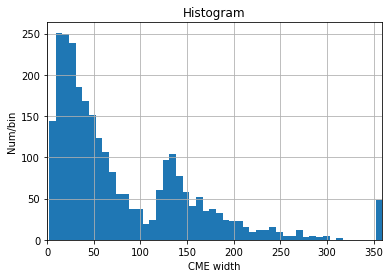

In [13]:
# try to reconstruct the histogram on widths (fig 10, found in gopalswami etal 2009;
#    https://link.springer.com/article/10.1007/s11038-008-9282-7)
# which does NOT show the bump
pre_2007 = c2_c3_data[c2_c3_data['datetime'] < '2007-01-01']
plot_hist(pd.to_numeric(pre_2007['Width']), nbins=50, what='CME width', ylog=False, xhigh=359)

In [15]:
# the gopalswami paper above references ~9000 CMEs between 1996 to 2007, we should have similar number!
# but we dont (the filtered CDAW catalog we have is less than this number; 
# Why? is it because we excluded poor events earlier, and if they were included would it then match??)
len(pre_2007)

2749

In [ ]:
plot_data(pd.to_numeric(c2_c3_data['Width']), pd.to_numeric(c2_c3_data['Linear']), xlabel='CME width', ylabel='Linear', title="CDAW", alpha=0.05)

In [ ]:
plot_data(pd.to_numeric(c2_c3_data['Width']), pd.to_numeric(c2_c3_data['Duration_C2']), xlabel='CME width', ylabel='C2 Duration', title="CDAW", alpha=0.01)

In [ ]:
n = 1000 # len(c2_c3_data)
x = pd.to_numeric(c2_c3_data['Width'])
y = pd.to_numeric(c2_c3_data['Linear'])
plt.hexbin(x,y)
plt.xlabel("Width")
plt.ylabel("Linear")
plt.show()

In [ ]:
n = 100 # len(c2_c3_data)
x = pd.to_numeric(c2_c3_data['Width'])
y = pd.to_numeric(c2_c3_data['Duration_C2'])
plt.hexbin(x,y)
plt.xlabel("Width")
plt.ylabel("Duration C2")
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
#plt.axis.set_xticks(20)
plt.show()

In [ ]:
c2_c3_data

In [ ]:
# pull out SBO group, 50~<Width~<90 from Vourlidas and Webb 2018
sbo_data = c2_c3_data[pd.to_numeric(c2_c3_data['Width']) > 50.]
sbo_data = sbo_data[pd.to_numeric(sbo_data['Width']<90.)]
sbo_data = c2_c3_data

In [ ]:
# clean up data, make numeric, get rid of asterisk in columns
sbo_data['width'] = pd.to_numeric(sbo_data['Width'])
#sbo_data['central'] = pd.to_numeric(sbo_data['Central'])
sbo_data['linear'] = pd.to_numeric(sbo_data['Linear'])
sbo_data['mpa'] = pd.to_numeric(sbo_data['MPA'])
#sbo_data['cpa_mpa'] = sbo_data['central'] - sbo_data['mpa']
sbo_data['c2_time'] = pd.to_numeric(sbo_data['Duration_C2'])
sbo_data['mass'] = pd.to_numeric([i.replace('*', '').replace('-','0') for i in sbo_data['Mass']])
sbo_data['kinetic'] = pd.to_numeric([i.replace('*', '').replace('-','0') for i in sbo_data['Kinetic']])
sbo_data['accel'] = pd.to_numeric([i.replace('*', '').replace('--', '0') for i in sbo_data['Accel']])
sbo_data[['accel', 'Accel', 'mass', 'Mass', 'Central', 'kinetic']]

In [ ]:
# accel
plot_hist(pd.to_numeric(sbo_data['accel']), nbins=20, what='accel', ylog=True)
plot_data(sbo_data['accel'], sbo_data['kinetic'], ylabel='kinetic', xlabel='accel', title="CDAW", alpha=0.1)
plot_data(sbo_data['accel'], sbo_data['mass'], ylabel='mass', xlabel='accel', title="CDAW", alpha=0.1)
plot_data(sbo_data['accel'], sbo_data['linear'], xlabel='accel', ylabel='linear speed', title="CDAW", alpha=0.1)

In [ ]:
# kinetic
plot_data(sbo_data['kinetic'], sbo_data['linear'], xlabel='kinetic', ylabel='linear speed', title="CDAW", alpha=0.1)
plot_data(sbo_data['kinetic'], sbo_data['width'], xlabel='kinetic', ylabel='width', title="CDAW", alpha=0.1)
plot_data(sbo_data['kinetic'], 0.5*1000000*10000*sbo_data['linear']*sbo_data['linear']*sbo_data['mass'], xlabel='kinetic', ylabel='calc KE', title="", alpha=0.1)

In [ ]:
# width
plot_data(sbo_data['width'], sbo_data['kinetic'], ylabel='kinetic', xlabel='width', title="", alpha=0.01, ylog=True)
plot_data(sbo_data['width'], sbo_data['mass'], ylabel='mass', xlabel='width', title="", alpha=0.05, ylog=True)
plot_data(sbo_data['width'], abs(sbo_data['accel']), ylabel='abs accel', xlabel='width', title="", alpha=0.01, ylog=True)

In [ ]:
# mass
plot_hist(pd.to_numeric(sbo_data['mass']), nbins=20, what='mass', ylog=True)
plot_data(sbo_data['mass'], sbo_data['width'], ylabel='width', xlabel='Mass', title="CDAW", alpha=0.1, xlog=True)
plot_data(sbo_data['mass'], sbo_data['kinetic'], ylabel='kinetic', xlabel='Mass', title="CDAW", alpha=0.01, ylog=True, xlog=True)
plot_data(sbo_data['kinetic'], sbo_data['mass'], ylabel='mass', xlabel='kinetic', title="CDAW", alpha=0.01, ylog=True, xlog=True)
plot_data(sbo_data['mass'], sbo_data['accel'], ylabel='accel', xlabel='Mass', title="CDAW", alpha=0.1, xlog=True)

In [ ]:
# cpa-mpa
#plot_hist(pd.to_numeric(sbo_data['cpa_mpa']), nbins=20, what='CPA - MPA', ylog=True)
#plot_data(sbo_data['kinetic'], sbo_data['cpa_mpa'], xlabel='kinetic', ylabel='CPA-MPA', title="CDAW", alpha=0.1)
#plot_data(sbo_data['kinetic'], abs(sbo_data['cpa_mpa']), xlabel='kinetic', ylabel='Abs(CPA-MPA)', title="CDAW", alpha=0.1, ylog=False)

In [ ]:
# C2 Duration
plot_hist(sbo_data['c2_time'], nbins=20, what='C2 duration', ylog=True)
plot_data(sbo_data['c2_time'], sbo_data['mass'], ylabel='mass', xlabel='C2 time', title="CDAW", alpha=0.1, ylog=True)
plot_data(sbo_data['c2_time'], sbo_data['kinetic'], ylabel='kinetic', xlabel='C2 time', title="", alpha=0.1, ylog=True)
plot_data(sbo_data['c2_time'], abs(sbo_data['accel']), ylabel='abs(accel)', xlabel='C2 time', title="", alpha=0.1, ylog=True)

In [ ]:
c2_c3_data

In [ ]:
test = c2_c3_data[c2_c3_data['Date'] == '2014/01/10']
test